# Base de données répertoriant les indicateurs de délinquance et de criminalité (1996-2022 en France)

### Sommaire

* [Récupération et nettoyage des données du Ministère de l'Intérieur](#section1)
* [Conception des indicateurs de délinquance et criminalité](#section2)
    * [Ajout des estimations de population](#section21)
    * [Calcul des taux](#section22)
    * [Autres variables adjacentes](#section23)
* [Ajout de variables de contrôle pour une future modélisation](#section3)
    * [Densité urbaine (Table départementale)](#section31)
    * [Evolution du taux de pauvreté (Table nationale)](#section32)
* [Sauvegarde des tableaux de données finalisés](#section4)

### Récupération et nettoyage des données du Ministère de l'Intérieur relative aux crimes et délits<a class="anchor" id="section1"></a>

(NB : Les liens hypertextes présents dans ce markdown et les suivants renvoient aux sites internet sur lesquelles les tableaux de données ont été téléchargées et ne correspondent pas aux URL de téléchargement, l'exécution des cellules de code permet de télécharger automatiquement les jeux de données)

Nous avons récupéré, grâce à l'open data du ministère de l'intérieur ([ici](https://www.data.gouv.fr/fr/datasets/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/)) les données relatives aux crimes et délits enregistrés dans chaque département et en France entre janvier 1996 et août 2022. Ce jeu de données a été produit successivement par le Ministère de l'Intérieur puis par le SSMSI depuis sa création en 2014. 

Issu directement des applications informatiques de gestion, il n'est pas retraité et reste assez brut. Entre autres, il ne nous donne accès qu'au nombre d'infractions (classées par type) par département, nous l'avons donc complété avec des données d'estimation de population pour obtenir des taux d'infractions plutôt que des chiffres bruts. Nous avons ensuite ajouté à notre base de données des indices de localisation pour nous permettre de réaliser des représentations géographiques dans notre partie de statistiques descriptives.

In [1]:
!pip install openpyxl
!pip install lxml
!pip install bs4
!pip install geopandas

In [2]:
import requests
import pandas as pd
import geopandas as gpd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import s3fs
from scipy.signal import savgol_filter
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.colors as colors
import os
from IPython.display import Image, display
import bs4

In [3]:
# URL de téléchargement du fichier
url = "https://static.data.gouv.fr/resources/chiffres-departementaux-mensuels-relatifs-aux-crimes-et-delits-enregistres-par-les-services-de-police-et-de-gendarmerie-depuis-janvier-1996/20221031-102847/tableaux-4001-ts.xlsx" 

# Dossier de destination pour enregistrer le fichier téléchargé
dossier_destination = "data"
os.makedirs(dossier_destination, exist_ok=True)

# Chemin du fichier téléchargé
fichier_telecharge = os.path.join(dossier_destination, "fichier.xlsx")

# Téléchargement du fichier
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_telecharge, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_telecharge)

# Chargement des onglets du fichier Excel en DataFrames
print("Chargement des onglets dans des DataFrames...")
data = pd.read_excel(fichier_telecharge, sheet_name=None)  # `sheet_name=None` charge tous les onglets

# Fusion des onglets dans un unique DataFrame avec une colonne pour identifier le département (ou la zone)
données_police = pd.concat(
    [df.assign(Zone=nom_onglet) for nom_onglet, df in data.items()],
    ignore_index=True
)

# Suppression du fichier téléchargé 
os.remove(fichier_telecharge)
print("Fichier téléchargé supprimé.")

Téléchargement en cours...
Téléchargement terminé: data/fichier.xlsx
Chargement des onglets dans des DataFrames...
Fichier téléchargé supprimé.


On sépare notre premier jeu de données (données police) en deux pour obtenir une base de données départementale et une base nationale.


In [4]:
# Données pour la france entière
df_nat = données_police[données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

# Données départementales
df_dep = données_police[~données_police['Zone'].isin(['France_Entière', 'France_Métro'])]

Le format des tableaux de données actuel indique les dates en tant que variable (colonne) tandis que chaque ligne correspond à un type d'infraction. Les valeurs sont des occurrences (voir ci-dessous). 

| Index  | Libellé | Zone | _2022_08 | _2022_07 | ... | _1996_01 |
|-----------|----------|----------|----------|----------|----------|----------|
| Type 1    | Libellé  1 | France | Valeur 1 | Valeur 3 | Valeur 5 | Valeur 8 |
| Type 2    | Libellé  2 | France | Valeur 2 | Valeur 4 | Valeur 6 | Valeur 9 |

Nous préférions avoir une colonne indiquant la date car il nous semblait plus simple de filtrer par date et d'ajouter de nouvelle colonnes d'information ainsi (exemple ci-dessous). Ainsi, chaque ligne correspond à un incident.

| Index | Libellé | Zone | Date |
|-------|---------|------|------|
| Type 1 | Libellé 1 | Zone a | _2022_08 |
| Type 2 | Libellé 2 | Zone a | _2022_08 |
| ... | ... | ... | ... |
| Type 1 | Libellé 1 | Zone f | _2012_05 |
| ... | ... | ... | ... |
| Type 34 | Libellé 34 | Zone z | _1996_01 |

Nous avons donc restructurer les deux tableaux de données en format long.


In [5]:
# Transformer le tableau (échelle nationale) en format "long"
df_nat = df_nat.melt(id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
                  var_name='Date',  # Nom pour la colonne de dates
                  value_name='Nombre')  # Nom pour la colonne des valeurs

# Transformer le tableau (échelle départementale) en format "long"
df_dep = df_dep.melt(
    id_vars=['Index', 'libellé index', 'Zone'],  # Colonnes fixes
    var_name='Date',  # Nom pour la colonne de dates
    value_name='Nombre'  # Nom pour la colonne des valeurs
)
#On renomme la colonne 'Zone' en 'Département'
df_dep = df_dep.rename(columns={'Zone': 'Département'})

In [6]:
# Vérification de l'existence de doublons 
if df_dep.duplicated().any():
    print("Des doublons existent dans la base départementale.")
else:
    print("Aucun doublon trouvé dans la base nationale.")

if df_nat.duplicated().any():
    print("Des doublons existent dans le DataFrame.")
else:
    print("Aucun doublon trouvé dans le DataFrame.")

# Vérification de l'existence de valeurs manquantes
valeurs_manquantes_dep = df_dep[df_dep.isna().any(axis=1)]
print(f"Nombre de lignes avec des valeurs manquantes dans la base départementale: {len(valeurs_manquantes_dep)}")
print(f"Départements concernés :{valeurs_manquantes_dep["Département"].unique()}")

valeurs_manquantes_nat = df_nat[df_nat.isna().any(axis=1)]
print(f"Nombres de lignes avec des valeurs manquantes dans la base nationale: {len(valeurs_manquantes_nat)}")


Aucun doublon trouvé dans la base nationale.
Aucun doublon trouvé dans le DataFrame.
Nombre de lignes avec des valeurs manquantes dans la base départementale: 73188
Départements concernés :['977' '978' '986' '971' '972' '973' '974' '975' '976' '987' '988']
Nombres de lignes avec des valeurs manquantes dans la base nationale: 5136


Aucun doublons n'est présent dans les données récupérées du Ministère de l'Intérieur (il était indiqué sur data.gouv.fr que c'était une éventualité). En revanche, les données concernant les territoires d'outre-mer ne sont pas disponibles avant une certaine date, nos deux DataFrames ont donc des valeurs manquantes, pour les départements concernés dans la base départementale et dans la catégorie France_Entière pour la base nationale. 

Comme les données (de population, densité, pauvreté etc.) ajoutée ensuite dans les bases présentaient elles-aussi des manquements au niveau des territoires d'outre-mer, nous avons décidé de les exclure dès maintenant de nos bases de données.

In [7]:
# Suppression des données hors métropole
df_dep = df_dep[(df_dep['Département'] <= '95') | (df_dep['Département'].isin(['2A', '2B']))]

df_nat = df_nat[df_nat['Zone'] != 'France_Entière']

### Conception des indicateurs de délinquance et de criminalité<a class="anchor" id="section2"></a>

##### Ajout des estimations de population<a class="anchor" id="section21"></a>

Pour obtenir les taux d'infractions, nous devons ajouter à nos deux tableaux de données, les estimations de population récupérée sur le site de l'INSEE à l'échelle nationale ([ici](https://www.insee.fr/fr/statistiques/serie/000436387#Tableau)) et départementale ([et là](https://catalogue-donnees.insee.fr/fr/explorateur/DS_ESTIMATION_POPULATION)). 

* ##### Sur la table nationale :

In [8]:
# URL de téléchargement du fichier
url = "https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions" 

# Dossier de destination
destination = "data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_zip = os.path.join(destination, "fichier.zip")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_zip, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_zip)

# Décompression du fichier zip
print("Décompression en cours...")
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    zip_ref.extractall(destination)
print("Décompression terminée.")

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

# Localisation et chargement du fichier valeurs_mensuelles.csv
fichier_cible = os.path.join(destination, "valeurs_mensuelles.csv")
if not os.path.exists(fichier_cible):
    raise FileNotFoundError("Le fichier valeurs_mensuelles.csv n'a pas été trouvé.")

print("Chargement du fichier valeurs_mensuelles.csv en DataFrame...")
data_valeurs_mensuelles = pd.read_csv(fichier_cible, delimiter=';', encoding='utf-8') 

# Suppression des fichiers 
os.remove(fichier_zip)
os.remove(os.path.join(destination, "caractéristiques.csv"))
os.remove(os.path.join(destination, "valeurs_mensuelles.csv"))

print("Processus terminé. Fichiers supprimés.")

Téléchargement en cours...
Téléchargement terminé: data/data_pop/fichier.zip
Décompression en cours...
Décompression terminée.
Fichiers présents après décompression : ['valeurs_mensuelles.csv', 'fichier_pop_dep.csv', 'caractéristiques.csv', 'fichier.zip']
Chargement du fichier valeurs_mensuelles.csv en DataFrame...
Processus terminé. Fichiers supprimés.


In [9]:
# Suppression des colonnes inutiles
data_valeurs_mensuelles.drop(columns=['Codes'], inplace=True)

# Suppression des trois premières lignes inutiles
data_valeurs_mensuelles = data_valeurs_mensuelles.iloc[3:]
data_valeurs_mensuelles.reset_index(drop=True, inplace=True)

# Transformation du format de la colonne de date pour préparer l'inner join
data_valeurs_mensuelles["Libellé"] = data_valeurs_mensuelles["Libellé"].str.replace("-", "_").apply(lambda x: f"_{x}")

# Renommer la colonne 'Démographie - Population au début du mois - France métropolitaine' car c'est bien trop long
data_valeurs_mensuelles = data_valeurs_mensuelles.rename(columns={'Démographie - Population au début du mois - France métropolitaine': 'Population'})

In [10]:
# Inner join sur les colonnes de date
df_nat_bis = pd.merge(
    df_nat,
    data_valeurs_mensuelles,
    left_on='Date',  # Colonnes de df_france
    right_on='Libellé', # Colonnes de data_valeurs_mensuelles
    how='inner'  # Type de jointure
)

#Les colonnes 'Date' et 'Libellé' sont identiques donc on supprime 'Libellé' (nom moins évocateurs)
df_nat_bis = df_nat_bis.drop(columns=["Libellé"])

#Visualisation du résultat
df_nat_bis

,Index,libellé index,Zone,Date,Nombre,Population
0,1,Règlements de compte entre malfaiteurs,France_Métro,_2022_08,11.0,65843
1,2,Homicides pour voler et à l'occasion de vols,France_Métro,_2022_08,0.0,65843
2,3,Homicides pour d'autres motifs,France_Métro,_2022_08,81.0,65843
3,4,Tentatives d'homicides pour voler et à l'occas...,France_Métro,_2022_08,3.0,65843
4,5,Tentatives homicides pour d'autres motifs,France_Métro,_2022_08,263.0,65843
...,...,...,...,...,...,...
34235,103,Infractions à l'exercice d'une profession règl...,France_Métro,_1996_01,61.0,57936
34236,104,Infractions au droit de l'urbanisme et de la c...,France_Métro,_1996_01,156.0,57936
34237,105,Fraudes fiscales,France_Métro,_1996_01,40.0,57936
34238,106,Autres délits économiques et financiers,France_Métro,_1996_01,127.0,57936


* ##### Sur la table départementale :

Contrairement aux données nationales, les données départementales récupérées sont disponibles en open data avec une granularité annuelle et non pas mensuelle. On conserve donc les données disponibles aux 1er janvier (date à laquelle sont faites les estimations de l'INSEE). Si on a, à l'avenir, besoin de données départementales mensuelles (et pas seulement annuelles) on tentera de linéariser les évolutions démographiques annuelles sur 12 mois.

In [11]:
# URL de téléchargement du fichier
url = "https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D" 

# Dossier de destination
destination = "data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier zip téléchargé
fichier_csv = os.path.join(destination, "fichier_pop_dep.csv")

# Téléchargement du fichier zip
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_csv, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_csv)

# Vérification des fichiers extraits
fichiers = os.listdir(destination)
print("Fichiers présents après décompression :", fichiers)

print("Chargement du fichier en DataFrame...")
pop_dep = pd.read_csv(fichier_csv, delimiter=';', encoding='utf-8') 

# On garde une sauvegarde de ces données car la maintenance du site nous a plusieurs fois empêché de faire tourner le code

Téléchargement en cours...
Téléchargement terminé: data/data_pop/fichier_pop_dep.csv
Fichiers présents après décompression : ['fichier_pop_dep.csv']
Chargement du fichier en DataFrame...


La maintenance du catalogue de données de l'INSEE nous a plusieurs fois empêché de faire tourner le code (la cellule précédente). On a donc conservé une sauvegarde de ce fichier (*fichier_pop_dep* dans ***data/data_pop***). En cas de problème d'exécution à ce niveau là, veuillez sortir la cellule suivante du mode commentaire et l'exécuter. 

In [12]:
'''
fichier = "data/data_pop/fichier_pop_dep.csv"
pop_dep = pd.read_csv(fichier, delimiter=';', encoding='utf-8') 
'''

'\nfichier = "data/data_pop/fichier_pop_dep.csv"\npop_dep = pd.read_csv(fichier, delimiter=\';\', encoding=\'utf-8\') \n'

In [13]:
#Suppression des colonnes non utilisées
pop_dep.drop(columns=['GEO_OBJECT', 'SEX', 'AGE', 'OBS_STATUS_FR', 'EP_MEASURE'], inplace=True)

#Modifications de la colonne 'TIME_PERIOD' pour pouvoir faire le futur inner join avec la table 'données départements'
pop_dep["TIME_PERIOD"] = pop_dep["TIME_PERIOD"].apply(
    lambda x: f"_{str(x)}_01" if not str(x).startswith("_") else str(x)
)

pop_dep = pop_dep.rename(columns={
    'TIME_PERIOD': 'Date',
    'GEO': 'Département',
    'OBS_VALUE': 'Population'
})

In [14]:
#Inner join sur les tables de population et d'infractions départementales
df_dep_bis = pd.merge(
    df_dep,
    pop_dep,
    on=['Département', 'Date'],  
    how='inner'
)

#Visualisation du résultat
df_dep_bis

,Index,libellé index,Département,Date,Nombre,Population
0,1,Règlements de compte entre malfaiteurs,01,_2022_01,0.0,668613
1,2,Homicides pour voler et à l'occasion de vols,01,_2022_01,0.0,668613
2,3,Homicides pour d'autres motifs,01,_2022_01,0.0,668613
3,4,Tentatives d'homicides pour voler et à l'occas...,01,_2022_01,0.0,668613
4,5,Tentatives homicides pour d'autres motifs,01,_2022_01,0.0,668613
...,...,...,...,...,...,...
277339,103,Infractions à l'exercice d'une profession règl...,95,_1996_01,0.0,1097809
277340,104,Infractions au droit de l'urbanisme et de la c...,95,_1996_01,1.0,1097809
277341,105,Fraudes fiscales,95,_1996_01,0.0,1097809
277342,106,Autres délits économiques et financiers,95,_1996_01,0.0,1097809


##### Calcul des taux de délinquance et de criminalité<a class="anchor" id="section22"></a>

Les tableaux traités ici comptent les 107 différentes catégories (index) d'infractions de "l'état 4001" enregistrées par les forces de sécurité. De nature, fréquence et variables de comptage variées, agglomérer ces index en un seul indicateur de délinquance est susceptible de masquer des phénomènes délinquants importants et, en effet, depuis 2012 le ministère de l'Intérieur a annoncé renoncer à l'utilisation d'indicateurs trop globaux. Aujourd'hui, une dizaine d'indicateurs sont utilisés par le SSMSI dans leurs bilans statistiques (le nombre peut varier selon la finesse de la typologie). On propose ici d'utiliser les 8 indicateurs principaux dénombrés dans le bilan statistique du SSMSI de 2013 ([téléchargable ici](https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental)), à savoir les *homicides*, *tentatives d'homicides*, *coups et blessures volontaires*, *violences sexuelles*, *atteintes aux biens avec violence contre les personnes*, *atteintes aux biens sans violence contre les personnes*, *infractions à la législation sur les stupéfiants* et *escroqueries*.

Il est important de noter que les chiffres disponibles ici sont ceux de la criminalité observée et enregistrée qui reste un indicateur très imparfait. D'une part il ne reflète pas le nombre réel d'infractions, mais n'est pas non plus égal à une proportion de ce nombre constante dans le temps. Des décisions politiques et de gestion (comme la politique du chiffre à partir de 2002, les variations de moyens alloués aux forces de sécurité) peuvent impacter la part de la criminalité enregistrée par rapport à la criminalité effective. D'autre part cette partie observée n'est pas la même pour tous les types d'infractions. En particulier, les violences sexuelles étant très sous-déclarées et leur augmentation enregistrée étant quasiment uniquement dûe à la hausse des déclarations (au vue des enquêtes de victimation), on préférera les traiter à part.

Fort de ces remarques, nous allons, dans cette section, calculer les 8 indicateurs présentés à partir des 107 catégories à notre disposition. On utilise pour cela la section méthodologie du bilan de 2023 pour savoir quels index composent quelles catégories. Notons que tous les index ne sont pas utilisés, certaines infractions ne correspondant pas à ce qu'on considère usuellement comme phénomène délinquant (criminalité en col blanc, atteintes aux intérêts fondamentaux de la nation, fraude fiscale entre autres).

In [15]:
# Mapping des indicateurs de délinquance et infractions associées 
mapping = {
    "Homicides": [1, 2, 3, 6, 51],
    "Tentatives d'homicides": [4, 5],
    "Coups et blessures volontaires": [7, 13],
    "Violences sexuelles": [45, 46, 47, 48, 49, 50],
    "Vols avec violence": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    "Vols sans violence": [27, 28, 29, 30, 32, 42, 43, 34, 35, 36, 37, 38, 62, 63, 65, 66, 67, 68],
    "Stupéfiants": [56, 57, 58, 59],
    "Escroquerie": [91, 86, 89, 90, 92],
}

In [16]:
# Calcul des indicateurs et stockage dans les DateFrames

# Listes pour stocker les indicateurs
indicateurs_dep = []  # Niveau départemental
indicateurs_fr = []  # Niveau national

# Boucle qui permet de parcourir les DataFrames pour chaque indicateur
for indicateur, infractions in mapping.items():

    # On ne conserve que les lignes avec les infractions correspondant à l'indicateur
    df_dep_filtre = df_dep_bis[df_dep_bis['Index'].isin(infractions)] 
    df_nat_filtre = df_nat_bis[df_nat_bis['Index'].isin(infractions)] 

    # Somme des occurences d'infractions par zone géographique et par date
    somme_ind_dep = (df_dep_filtre.groupby(["Date", "Département"])["Nombre"].sum()
        .reset_index() # Pour éviter que le groupby modifie l'index du DataFrame
    )
    somme_ind_nat = (df_nat_filtre.groupby(["Date", "Zone"])["Nombre"].sum()
        .reset_index()
    )
    
    # Ajouter une colonne pour libeller les indicateurs
    somme_ind_dep["Indicateur"] = indicateur
    somme_ind_nat["Indicateur"] = indicateur

    # Ajouter les colonnes de libellé et de sommes au résultat
    indicateurs_dep.append(somme_ind_dep)
    indicateurs_fr.append(somme_ind_nat)

    # Population à date et zone géographique donnée 
    pop_dep_ind = (df_dep_filtre.groupby(["Date", "Département"])["Population"].first())
    pop_nat_ind = (df_nat_filtre.groupby(["Date", "Zone"])["Population"].first())


# Combiner les résultats pour les indicateurs
df_indicateurs_dep = pd.concat(indicateurs_dep, ignore_index=True) 
df_indicateurs_nat = pd.concat(indicateurs_fr, ignore_index=True)

# Ajout des données de population départementale
df_indicateurs_dep = df_indicateurs_dep.merge(
    pop_dep_ind,
    on=["Date", "Département"],  
    how="left"                   
)

df_indicateurs_nat = df_indicateurs_nat.merge(
    pop_nat_ind,
    on=["Date", "Zone"],  
    how="left"
)

# Réorganisation des colonnes 
df_indicateurs_dep = df_indicateurs_dep[["Date", "Département", "Indicateur", "Nombre", "Population"]]
df_indicateurs_nat = df_indicateurs_nat[["Date", "Zone", "Indicateur", "Nombre", "Population"]] 

On crée ensuite une colonne avec les taux de délinquance pour chaque indicateurs en divisant les colonnes 'Nombre' et 'Population'

In [17]:
# Dans la base départementale
df_indicateurs_dep["Taux (/10 000)"] = (df_indicateurs_dep["Nombre"] / df_indicateurs_dep["Population"]) * 10000

# Dans la base nationale
df_indicateurs_nat["Population"] = pd.to_numeric(df_indicateurs_nat["Population"], errors='coerce') # Gérer les problèmes de formats de données
df_indicateurs_nat["Taux (/10 000)"] = (df_indicateurs_nat["Nombre"] / df_indicateurs_nat["Population"]) * 10 # La population est en milliers d'habitants

##### Autres variables<a class="anchor" id="section23"></a>

On ajoute ensuite quelques variables permettant de classifier temporellement les données (l'année, le mois, la saison).

In [18]:
# Conversion des colonnes 'Date' au format datetime
if not pd.api.types.is_datetime64_any_dtype(df_indicateurs_dep['Date']):
    df_indicateurs_dep['Date'] = pd.to_datetime(df_indicateurs_dep['Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
                             df_indicateurs_dep['Date'].str.extract(r'_(\d{4})_(\d{2})')[1], format='%Y-%m')

if not pd.api.types.is_datetime64_any_dtype(df_indicateurs_nat['Date']):
    df_indicateurs_nat['Date'] = pd.to_datetime(df_indicateurs_nat['Date'].str.extract(r'_(\d{4})_(\d{2})')[0] + '-' +
                             df_indicateurs_nat['Date'].str.extract(r'_(\d{4})_(\d{2})')[1], format='%Y-%m')

# Ajout d'une colonne indiquant l'année, le mois
df_indicateurs_dep['Année'] = df_indicateurs_dep['Date'].dt.year
df_indicateurs_dep['Mois'] = df_indicateurs_dep['Date'].dt.month

df_indicateurs_nat['Année'] = df_indicateurs_nat['Date'].dt.year
df_indicateurs_nat['Mois'] = df_indicateurs_nat['Date'].dt.month

# Dictionnaire des saisons avec les mois correspondants
saisons = {
    'Hiver': [12, 1, 2],
    'Printemps': [3, 4, 5],
    'Été': [6, 7, 8],
    'Automne': [9, 10, 11]
}

# Ajouter une colonne 'Saison' au dataframe en fonction du mois
def get_saison(mois):
    for saison, mois_list in saisons.items():
        if mois in mois_list:
            return saison
    return None  # Retourner None si le mois n'est pas trouvé (devrait pas arriver)

df_indicateurs_nat['Saison'] = df_indicateurs_nat['Mois'].apply(get_saison)

Afin de permettre de visualiser des évolutions d'indice, on crée une colonne de taux relatifs où on normalise tous les taux par la valeur en 1996. On n'ajoute cette colonne qu'au DataFrame national, car au niveau départemental les taux sont régulièrement à zéro pour les départements peu peuplés, ce qui donne beaucoup de valeurs non définie.

In [19]:
# Trier les données par indicateur et par date
df_indicateurs_nat = df_indicateurs_nat.sort_values(by=['Indicateur', 'Date']).reset_index(drop=True)

# Normaliser les valeurs à 1 pour la première valeur de chaque indicateur
df_indicateurs_nat['Taux relatif'] = df_indicateurs_nat.groupby('Indicateur')['Taux (/10 000)'].transform(lambda x: x / x.iloc[0])

### Ajouts de variables de contrôle pour une future modélisation<a class="anchor" id="section3"></a>

##### Densité urbaine<a class="anchor" id="section31"></a>

Dans le but d'effectuer une modélisation économétrique permettant d'évaluer l'effet de la législation sur les taux de criminalité, on a réfléchit à des variables de contrôle à inclure dans notre régression. La densité (comme proxy de la densité urbaine) nous semblait être un choix intéressant puisqu'on pourrait dresser l'hypothèse que les fortes densité peuvent favoriser l'émergence de violences interpersonnelles tout en compliquant l'action des forces de l'ordre.

Dans l'optique de réaliser une régression de panel, nous avons jugé qu'il s'agissait d'une bonne variable pour distinguer les départements entre eux notamment.

Dans la mesure où l'on a déjà récupéré les estimations de populations à l'échelle nationale et départementale, on n'a simplement qu'à récupérer les superficies cadastrales en km2 (celle utilisée par l'INSEE) des différents départements français en scrapant la page wikipédia correspondante ([juste là](https://fr.wikipedia.org/wiki/Superficie_des_d%C3%A9partements_fran%C3%A7ais)).

Les informations recherchée se trouvent sur le premier tableau de la page.

In [20]:
url_superficie = (
    "https://fr.wikipedia.org/wiki/Superficie_des_d%C3%A9partements_fran%C3%A7ais"
)

request_text = requests.get(url_superficie).content

page = bs4.BeautifulSoup(request_text, "lxml")

tableau_superficies=page.find("table")

print(tableau_superficies)

<table class="wikitable sortable">
<caption>
</caption>
<tbody><tr>
<th colspan="2" rowspan="3" scope="col">Départements
</th>
<th colspan="3" scope="col">Situation de 1950
</th>
<th colspan="4" scope="col">Situation de 2018
</th></tr>
<tr>
<th colspan="2" scope="col">Arrondissement
</th>
<th data-sort-type="number" rowspan="2" scope="col">Superficie <br/>officielle en km 2<sup class="reference" id="cite_ref-BL-1953-465_1-0"><a href="#cite_note-BL-1953-465-1"><span class="cite_crochet">[</span>1<span class="cite_crochet">]</span></a></sup>
</th>
<th rowspan="2" scope="col">Arrondissement
</th>
<th data-sort-type="number" rowspan="2" scope="col">Superficie cadastrale en km 2<br/>(Insee)
</th>
<th data-sort-type="number" rowspan="2" scope="col">Superficie géodésique<br/>(IGN - BD Carto)
</th>
<th rowspan="2" scope="col">Localisation
</th></tr>
<tr>
<th scope="col">Nom
</th>
<th data-sort-type="number" scope="col">Superf.
</th></tr>
<tr>
<td colspan="2"><b>Total France métropolitaine</b><

Le tableau est assez riche, on veut seulement en récupérer les codes de département et les superficies cadastrales ce qui exige encore quelques manipulations.

In [21]:
# Trouver toutes les lignes du tableau
table_body = tableau_superficies.find("tbody")
rows = table_body.find_all("tr")

# On parcours les lignes et on mets le texte dans un dictionnaire
dico_superficies = dict()
for row in rows:
    cols = row.find_all("td")
    cols = [ele.text.strip() for ele in cols]
    if len(cols) > 0:
        dico_superficies[cols[0]] = cols[1:]

# Visualisation
dico_superficies

{'Total France métropolitaine': ['',
  '',
  '551\xa0695,42',
  '',
  '543\xa0940',
  '550\xa0232,88',
  ''],
 '01': ['Ain',
  'Belley',
  '1\xa0311,66',
  '5825,6',
  'BelleyBourg-en-BresseGexNantua',
  '5\xa0762[Insee 1]',
  '5\xa0785,2[Brgm 1]',
  ''],
 'Bourg-en-Bresse': ['3\xa0173,75'],
 'Gex': ['412,58'],
 'Nantua': ['927,61'],
 '02': ['Aisne',
  'Château-Thierry',
  '1\xa0201,15',
  '7428,35',
  'Château-ThierryLaonSaint-QuentinSoissonsVervins',
  '7\xa0362[Insee 2]',
  '7\xa0437[Brgm 2]',
  ''],
 'Laon': ['2\xa0480,96'],
 'Saint-Quentin': ['1\xa0068,33'],
 'Soissons': ['1\xa0250,97'],
 'Vervins': ['1\xa0426,94'],
 '03': ['Allier',
  'Montluçon',
  '2\xa0340,98',
  '7381,83',
  'MontluçonMoulinsVichy',
  '7\xa0340[Insee 3]',
  '7\xa0378[Brgm 3]',
  ''],
 'Moulins': ['3\xa0035,65'],
 'Vichy[Note 1]': ['2\xa0005,2'],
 '04': ['Alpes-de-Haute-Provence',
  'Barcelonnette',
  '1\xa0151,18',
  '6988,4',
  'BarcelonnetteCastellaneDigne-les-BainsForcalquier',
  '6\xa0925[Insee 4]',
  '7\

Du fait de la structure assez complexe du tableau, toutes les clés ne sont pas des codes de départements, on trie le dictionnaire pour qu'il ne reste bien que les codes de département en faisant attention au cas de la Corse qui ne représente qu'une entrée dans le tableau de wikipédia mais qui contient bien deux départements.

In [22]:
dico_superficie = {
    key: value
    for key, value in dico_superficies.items()
    if (key.isdigit() and int(key) <= 95) or key == '20[Note 2]' or key == 'Bastia' 
}

dico_superficie

{'01': ['Ain',
  'Belley',
  '1\xa0311,66',
  '5825,6',
  'BelleyBourg-en-BresseGexNantua',
  '5\xa0762[Insee 1]',
  '5\xa0785,2[Brgm 1]',
  ''],
 '02': ['Aisne',
  'Château-Thierry',
  '1\xa0201,15',
  '7428,35',
  'Château-ThierryLaonSaint-QuentinSoissonsVervins',
  '7\xa0362[Insee 2]',
  '7\xa0437[Brgm 2]',
  ''],
 '03': ['Allier',
  'Montluçon',
  '2\xa0340,98',
  '7381,83',
  'MontluçonMoulinsVichy',
  '7\xa0340[Insee 3]',
  '7\xa0378[Brgm 3]',
  ''],
 '04': ['Alpes-de-Haute-Provence',
  'Barcelonnette',
  '1\xa0151,18',
  '6988,4',
  'BarcelonnetteCastellaneDigne-les-BainsForcalquier',
  '6\xa0925[Insee 4]',
  '7\xa0009[Brgm 4]',
  ''],
 '05': ['Hautes-Alpes',
  'Briançon',
  '2\xa0194,55',
  '5660,14',
  'BriançonGap',
  '5\xa0549[Insee 5]',
  '5\xa0697[Brgm 5]',
  ''],
 '06': ['Alpes-Maritimes',
  'Grasse',
  '1\xa0235,74',
  '4298,3',
  'GrasseNice',
  '4\xa0299[Insee 6]',
  '4\xa0302[Brgm 6]',
  ''],
 '07': ['Ardèche',
  'Largentière',
  '1\xa0933,75',
  '5556,07',
  'Largent

On peut maintenant faire de notre dictionnaire un DataFrame et effectuer quelques dernières opérations de tri pour ne conserver que la variable d'intérêt. A nouveau, les données concernants la Corse réclament un peu d'attention...

In [23]:
# Création du DataFrame
data_superficies = pd.DataFrame.from_dict(dico_superficie, orient="index")

# Mise à jour les libellé et les structures de ligne pour les départements corses
data_superficies = data_superficies.replace({
    "Corse": "Corse-du-Sud",  
    '1\xa0351,14': "Haute-Corse"  
})

ligne_bastia = data_superficies.loc['Bastia'] 
ligne_bastia[2], ligne_bastia[5] = ligne_bastia[5], ligne_bastia[2]
data_superficies.loc['Bastia'] = ligne_bastia

# Suppression des colonnes inutiles
data_superficies = data_superficies.drop(columns=[1, 2, 3, 4, 6, 7]) 

# Adaptation du format des superficies
data_superficies["Superficie (km2)"] = (
    data_superficies[5]
    .str.replace(r"\s+", "", regex=True) 
    .str.extract(r"^(\d+)", expand=False) 
    .astype(int) 
)
data_superficies = data_superficies.drop(columns=[5]) 

# Ajouter une colonne 'Département' qui donne les codes de département
data_superficies['Département'] = data_superficies.index

data_superficies = data_superficies.replace({
    "20[Note 2]": "2A",  
    'Bastia': "2B"  
})

data_superficies.rename(columns={ 0: 'Nom Département'}, inplace=True)

# Visualisation
data_superficies

,Nom Département,Superficie (km2),Département
01,Ain,5762,01
02,Aisne,7362,02
03,Allier,7340,03
04,Alpes-de-Haute-Provence,6925,04
05,Hautes-Alpes,5549,05
...,...,...,...
91,Essonne,1804,91
92,Hauts-de-Seine,176,92
93,Seine-Saint-Denis,236,93
94,Val-de-Marne,245,94


On peut maintenant ajouter cette variable à notre base départementale pour calculer les densités de population qu'on considère un proxy satisfaisant de la densité urbaine.

In [24]:
# Jointure sur la colonne "Département"
df_indicateurs_dep = pd.merge(df_indicateurs_dep, data_superficies, on='Département', how='inner')

# Création de la variable "Densité"
df_indicateurs_dep['Densité'] = df_indicateurs_dep['Population'] / df_indicateurs_dep['Superficie (km2)']

# Visualisation du résultat
df_indicateurs_dep

,Date,Département,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Nom Département,Superficie (km2),Densité
0,1996-01-01,01,Homicides,0.0,499310,0.000000,1996,1,Ain,5762,86.655675
1,1996-01-01,02,Homicides,1.0,538017,0.018587,1996,1,Aisne,7362,73.080277
2,1996-01-01,03,Homicides,0.0,349376,0.000000,1996,1,Allier,7340,47.598910
3,1996-01-01,04,Homicides,0.0,137453,0.000000,1996,1,Alpes-de-Haute-Provence,6925,19.848809
4,1996-01-01,05,Homicides,0.0,118526,0.000000,1996,1,Hautes-Alpes,5549,21.359885
...,...,...,...,...,...,...,...,...,...,...,...
20731,2022-01-01,91,Escroquerie,659.0,1319836,4.993045,2022,1,Essonne,1804,731.616408
20732,2022-01-01,92,Escroquerie,1634.0,1641277,9.955663,2022,1,Hauts-de-Seine,176,9325.437500
20733,2022-01-01,93,Escroquerie,898.0,1679240,5.347657,2022,1,Seine-Saint-Denis,236,7115.423729
20734,2022-01-01,94,Escroquerie,789.0,1421887,5.548964,2022,1,Val-de-Marne,245,5803.620408


##### Evolution du taux de pauvreté<a class="anchor" id="section32"></a>

Le caractère criminogène de la pauvreté est largement documenté, nous avons donc également décidé d'inclure cette variable comme variable de contrôle. On a récupéré, toujours sur le site de l'INSEE ([là, plus précisement](https://www.insee.fr/fr/statistiques/3564980?utm_source=chatgpt.com#tableau-figure1)), l'évolution du taux de pauvreté en France défini comme le fait d'être en dessous de 60% du niveau de vie médian.

In [25]:
# URL de téléchargement du fichier Excel
url = "https://www.insee.fr/fr/statistiques/fichier/3564980/reve-pauv-intensite.xlsx"

# Dossier de destination
destination = "/home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop"
os.makedirs(destination, exist_ok=True)

# Chemin du fichier Excel téléchargé
fichier_excel = os.path.join(destination, "reve_pauv_intensite.xlsx")

# Téléchargement du fichier Excel
print("Téléchargement en cours...")
response = requests.get(url, stream=True)
with open(fichier_excel, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Téléchargement terminé:", fichier_excel)

# Vérification de l'existence du fichier téléchargé
if os.path.exists(fichier_excel):
    print("Fichier téléchargé avec succès.")
else:
    print("Le téléchargement a échoué.")

# Chargement du fichier Excel en DataFrame
print("Chargement du fichier Excel en DataFrame...")
df = pd.read_excel(fichier_excel)

# Supprimer le fichier Excel une fois que le DataFrame est chargé
os.remove(fichier_excel)
print(f"Le fichier {fichier_excel} a été supprimé.")

Téléchargement en cours...
Téléchargement terminé: /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/reve_pauv_intensite.xlsx
Fichier téléchargé avec succès.
Chargement du fichier Excel en DataFrame...
Le fichier /home/onyxia/work/Python-pour-la-data-science-2A/data/data_pop/reve_pauv_intensite.xlsx a été supprimé.


In [26]:
# Suppression des lignes inutiles
df_pauvreté = df[df['Intensité de la pauvreté'].isin(['Indicateur', 'Intensité de la pauvreté5 (en %)'])]
df_pauvreté = df_pauvreté.drop(10)

# Modification des colonnes concernant l'année (en double à cause d'un changement de méthodologie)
df_pauvreté = df_pauvreté.drop('Unnamed: 27', axis=1)
df_pauvreté= df_pauvreté.replace("20203 4", 2020.0, )

# On renomme les différentes colonnes avec les années correspondantes 
annees = df_pauvreté.iloc[0, 1:].values.astype(int)
df_pauvreté.columns = ['Année'] + list(annees) 
df_pauvreté = df_pauvreté.drop(2)

# On transforme le Dataframe pour obtenir un format long plutôt que wide
df_pauvreté_bis = df_pauvreté.melt( var_name='Année', value_name='Taux de pauvreté (%)' )
df_pauvreté_bis = df_pauvreté_bis.drop([0, 16, 19]) # Suppression de doublons
df_pauvreté_bis.reset_index(drop=True, inplace=True)

df_pauvreté_bis

/tmp/ipykernel_245148/1905567104.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pauvreté= df_pauvreté.replace("20203 4", 2020.0, )


,Année,Taux de pauvreté (%)
0,1996,19.3
1,1997,18.8
2,1998,18.4
3,1999,17.9
4,2000,18.0
5,2001,17.2
6,2002,16.6
7,2003,18.4
8,2004,18.0
9,2005,18.8


On ajoute maintenant cette nouvelle variable à la base nationale. Nous n'avons pas réussi à trouver ces données en open data à l'échelle départementale malheureusement.

In [27]:
# Jointure sur les annnées
df_indicateurs_nat = pd.merge(df_indicateurs_nat, df_pauvreté_bis, on='Année', how='inner')

In [28]:
# Visualisation
df_indicateurs_nat.sample()
df_indicateurs_dep.sample()

,Date,Département,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Nom Département,Superficie (km2),Densité
5046,2021-01-01,54,Tentatives d'homicides,4.0,732486,0.054609,2021,1,Meurthe-et-Moselle,5246,139.627526


### Sauvegarde des tableaux de données finalisés<a class="anchor" id="section4"></a>

In [29]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "anhlinh"
fs.ls(MY_BUCKET)

# Sauvegarde dans S3
MY_BUCKET = "anhlinh"
FILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"

with fs.open(FILE_PATH_OUT_S3, "w") as file_out:
    df_indicateurs_dep.to_csv(file_out)

# Sauvegarde dans S3
MY_BUCKET = "anhlinh"
FILE_PATH_OUT_S3 = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"

with fs.open(FILE_PATH_OUT_S3, "w") as file_out:
    df_indicateurs_nat.to_csv(file_out)

fs.ls(f"{MY_BUCKET}/diffusion")

['anhlinh/diffusion/df_indicateurs_dep.csv',
 'anhlinh/diffusion/df_indicateurs_nat.csv']


# **!!!!!!!**








# **A SUPPRIMER MAIS AVANT VERIF AVEC WIWI ET ARTHUR ET VERIF QUE TOUT TOURNE BIEN DONC PAS SUP TOUT DE SUITE**








# **!!!!!!**

##### Ajout de contours géographiques sur la base de données départementales 

On installe geopandas pour pouvoir faire de la cartographie et on charge ensuite les contours de département eux aussi obtenu sur l'open data de l'Etat ([ici](https://www.data.gouv.fr/fr/datasets/carte-des-departements-2-1/)).

In [30]:
%pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [31]:
#URL de téléchargement des contours départementaux
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
contours_dpt = gpd.read_file(url)

<Axes: >

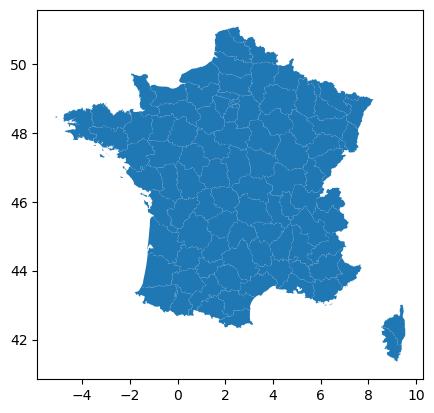

In [32]:
#Visualisation des contours
contours_dpt.plot()

In [33]:
contours_dpt.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [34]:
# Créer le dictionnaire des géométries via une compréhension
dictionnaire_geo = {row['code']: row['geometry'] for _, row in contours_dpt.iterrows()}

In [35]:
print(dictionnaire_geo)

{'01': <POLYGON ((4.78 46.177, 4.78 46.189, 4.783 46.192, 4.787 46.196, 4.793 46.20...>, '02': <POLYGON ((3.173 50.011, 3.174 50.012, 3.179 50.013, 3.18 50.012, 3.183 50.0...>, '03': <POLYGON ((3.032 46.795, 3.034 46.791, 3.036 46.789, 3.037 46.784, 3.037 46....>, '04': <POLYGON ((5.676 44.191, 5.678 44.191, 5.682 44.19, 5.684 44.19, 5.686 44.18...>, '05': <POLYGON ((6.261 45.127, 6.264 45.126, 6.267 45.125, 6.268 45.122, 6.269 45....>, '06': <MULTIPOLYGON (((7.067 43.514, 7.067 43.515, 7.061 43.516, 7.06 43.515, 7.05...>, '2A': <MULTIPOLYGON (((8.586 41.874, 8.587 41.876, 8.591 41.878, 8.592 41.878, 8.5...>, '2B': <MULTIPOLYGON (((9.409 43.022, 9.407 43.023, 9.406 43.024, 9.404 43.026, 9.4...>, '07': <POLYGON ((4.483 45.236, 4.488 45.232, 4.491 45.232, 4.499 45.234, 4.504 45....>, '08': <POLYGON ((4.233 49.958, 4.237 49.959, 4.24 49.959, 4.241 49.961, 4.245 49.9...>, '09': <POLYGON ((1.688 43.274, 1.691 43.272, 1.692 43.27, 1.695 43.268, 1.697 43.2...>, '10': <POLYGON ((3.415 48.39, 3

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, MultiPolygon

def plot_departments(dictionnaire_geo, figsize=(12, 16), vertical_stretch=1.3):
    """
    Génère une carte de France à partir d'un dictionnaire de polygones de départements
    
    Args:
        dictionnaire_geo (dict): Dictionnaire avec codes de départements et polygones Shapely
        figsize (tuple): Taille de la figure matplotlib
        vertical_stretch (float): Facteur d'étirement vertical (>1 pour plus de hauteur)
    """
    # Créer la figure et l'axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Liste pour stocker les patches (polygones)
    patches = []
    
    # Parcourir les départements
    for dept_code, geometry in dictionnaire_geo.items():
        try:
            # Gérer à la fois Polygon et MultiPolygon
            if isinstance(geometry, Polygon):
                geometries = [geometry]
            elif isinstance(geometry, MultiPolygon):
                geometries = list(geometry.geoms)
            else:
                print(f"Avertissement : {dept_code} n'est pas un polygone valide")
                continue
            
            # Traiter chaque composante de la géométrie
            for poly in geometries:
                # Extraire les coordonnées externes du polygone
                exterior_coords = list(poly.exterior.coords)
                
                # Étirer verticalement les coordonnées
                stretched_coords = [(x, y * vertical_stretch) for x, y in exterior_coords]
                
                # Créer un patch matplotlib pour chaque département
                polygon = MplPolygon(stretched_coords, closed=True, 
                                     edgecolor='black', 
                                     facecolor='lightgray', 
                                     linewidth=0.5, 
                                     alpha=0.7)
                patches.append(polygon)
        
        except Exception as e:
            print(f"Erreur pour le département {dept_code}: {e}")
    
    # Ajouter les patches à la collection
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    
    # Ajuster automatiquement les limites
    ax.autoscale()
    
    # Personnalisation de la carte
    ax.set_title('Carte de France par Départements', fontsize=15)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# plot_departments(dictionnaire_geo)

# Fonctions utilitaires supplémentaires
def plot_departments_with_colors(dictionnaire_geo, color_dict=None, figsize=(15, 10)):
    """
    Génère une carte de France avec des couleurs personnalisées
    
    Args:
        dictionnaire_geo (dict): Dictionnaire avec codes de départements et polygones Shapely
        color_dict (dict, optional): Dictionnaire de codes de départements et couleurs
        figsize (tuple): Taille de la figure matplotlib
    """
    # Créer la figure et l'axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Liste pour stocker les patches (polygones)
    patches = []
    
    # Parcourir les départements
    for dept_code, geometry in dictionnaire_geo.items():
        try:
            # Gérer à la fois Polygon et MultiPolygon
            if isinstance(geometry, Polygon):
                geometries = [geometry]
            elif isinstance(geometry, MultiPolygon):
                geometries = list(geometry.geoms)
            else:
                print(f"Avertissement : {dept_code} n'est pas un polygone valide")
                continue
            
            # Choisir la couleur
            color = color_dict.get(dept_code, 'lightgray') if color_dict else 'lightgray'
            
            # Traiter chaque composante de la géométrie
            for poly in geometries:
                # Extraire les coordonnées externes du polygone
                exterior_coords = list(poly.exterior.coords)
                
                # Créer un patch matplotlib pour chaque département
                polygon = MplPolygon(exterior_coords, closed=True, 
                                     edgecolor='black', 
                                     facecolor=color, 
                                     linewidth=0.5, 
                                     alpha=0.7)
                patches.append(polygon)
        
        except Exception as e:
            print(f"Erreur pour le département {dept_code}: {e}")
    
    # Ajouter les patches à la collection
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    
    # Ajuster automatiquement les limites
    ax.autoscale()
    
    # Personnalisation de la carte
    ax.set_title('Carte de France par Départements', fontsize=15)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

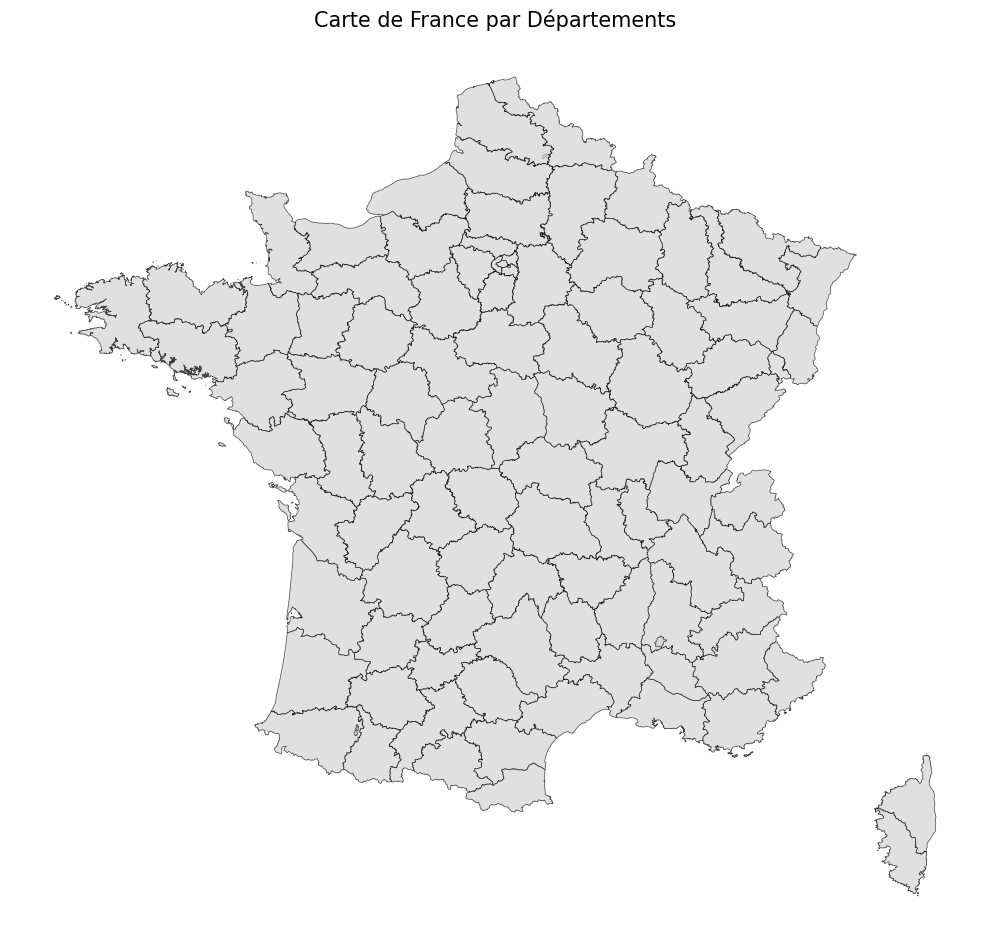

In [37]:
# Personnaliser aussi la taille de la figure
plot_departments(dictionnaire_geo, figsize=(10, 18), vertical_stretch=1.4)

On joint ensuite notre table départementale avec la table de contours départementaux. On note que les contours sont uniquement métropolitains et que la table obtenue ne concernera donc que les départements métropolitains. Etant donnée les défauts de données existant également pour la table nationale, on ne traitera que les département métropolitains.

In [38]:
#Préparation de la table 'contours_dpt'
contours_dpt = contours_dpt.rename(columns={'code': 'Département'})

In [39]:
# Inner join avec geopandas (gpd.merge)
dataframe_dep = dataframe 
'''
.merge(
    contours_dpt,
    on=['Département'],
    how='inner'  # Conserve uniquement les lignes correspondantes
)

# Renommer les colonnes comme dans ton exemple
dataframe_dep = dataframe_dep.rename(columns={'geometry': 'Géométrie', 'nom': 'Nom'})

# Convertir en GeoDataFrame si nécessaire (si "contours_dpt" est déjà un GeoDataFrame, cette étape peut ne pas être nécessaire)
dataframe_dep = gpd.GeoDataFrame(dataframe_dep, geometry='Géométrie')
'''
# Vérifier le résultat
dataframe_dep.head()


NameError: name 'dataframe' is not defined

''' 

https://mobile.interieur.gouv.fr/Interstats/Publications/Hors-collection/La-mesure-statistique-de-la-delinquance-AJ-Penal-Dalloz

https://www.interieur.gouv.fr/Media/SSMSI/Files/Interstats-Methode-N-3-La-premiere-generation-des-indicateurs-statistiques-des-crimes-et-delits-enregistres-par-la-police-et-la-gendarmerie-Octobre-2015/?nomobredirect=true

https://mobile.interieur.gouv.fr/Interstats/Actualites/Insecurite-et-delinquance-en-2023-bilan-statistique-et-atlas-departemental

'''

Fort de ces remarques, on va dans cette section calculer les 8 indicateurs présentés à partir des 107 catégories à notre disposition. On utilise pour cela la section méthodologie du bilan de 2023 pour savoir quels index composent quelles catégories. On note que tous les index ne sont pas utilisés, certaines infractions ne correspondant pas ce qu'on considère usuellement comme phénomène délinquant (criminalité en col blanc, atteintes aux intérêts fondamentaux de la nation, fraude fiscale entre autres exemples).

In [ ]:
# Dictionnaire des saisons avec les mois correspondants
saisons = {
    'Hiver': ['12', '01','02'],
    'Printemps': ['03','04','05'],
    'Été': ['06', '07', '08'],
    'Automne': ['09', '10', '11']
}

# Ajouter une colonne 'Saison' au dataframe en fonction du mois
def get_saison(mois):
    for saison, mois_list in saisons.items():
        if mois in mois_list:
            return saison
    return None  # Retourner None si le mois n'est pas trouvé (devrait pas arriver)

df_indicateurs_nat['Saison'] = df_indicateurs_nat['Mois'].apply(get_saison)

df_indicateurs_nat.head()

,Date,Zone,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Saison,Taux relatif,Taux de pauvreté (%)
0,1996-01-01,France_Métro,Coups et blessures volontaires,5616.0,57936,0.969345,1996,1,None,1.000000,19.3
1,1996-02-01,France_Métro,Coups et blessures volontaires,6115.0,57943,1.055347,1996,2,None,1.088722,19.3
2,1996-03-01,France_Métro,Coups et blessures volontaires,6668.0,57951,1.150627,1996,3,None,1.187015,19.3
3,1996-04-01,France_Métro,Coups et blessures volontaires,6800.0,57963,1.173162,1996,4,None,1.210262,19.3
4,1996-05-01,France_Métro,Coups et blessures volontaires,7415.0,57976,1.278978,1996,5,None,1.319424,19.3


### Partie de stat desc il faudra la déplacer probablement

In [ ]:
# Définir la charte graphique pour qu'elle soit uniforme entre les différentes stats descriptives (on veut que nos graphiques matchent avec nos cartes)
charte_graphique = {
    "Vols sans violence": "Magenta",
    "Escroquerie": "Green",
    "Coups et blessures volontaires": "Cyan",
    "Stupéfiants": "Pink",
    "Vols avec violence": "Red",
    "Violences sexuelles" : "Orange",
    "Tentatives d'homicides" : "Blue",
    "Homicides" : "Purple"
}

In [ ]:
# Dictionnaire associant chaque indicateur à une couleur spécifique
charte_graphique2 = {
    "Vols sans violence": "PuRd",
    "Escroquerie": "BuGn",
    "Coups et blessures volontaires": "Greens",
    "Stupéfiants": "RdPu",
    "Vols avec violence": "Reds",
    "Violences sexuelles": "Oranges",
    "Tentatives d'homicides": "Blues",
    "Homicides": "Purples"
}

Ajoutons une colonne donnant les taux relatifs dns notre dataframe df_indicateurs_nat pour nous permettre d'évaluer des variations relatives et pas seulement en valeur brute.

In [ ]:
'''
# Trier les données par indicateur et par date
df_indicateurs_nat = df_indicateurs_nat.sort_values(by=['Indicateur', 'Date']).reset_index(drop=True)

# Normaliser les valeurs à 1 pour la première valeur de chaque indicateur
df_indicateurs_nat['Taux relatif'] = df_indicateurs_nat.groupby('Indicateur')['Taux (/10 000)'].transform(lambda x: x / x.iloc[0])
'''

"\n# Trier les données par indicateur et par date\ndf_indicateurs_nat = df_indicateurs_nat.sort_values(by=['Indicateur', 'Date']).reset_index(drop=True)\n\n# Normaliser les valeurs à 1 pour la première valeur de chaque indicateur\ndf_indicateurs_nat['Taux relatif'] = df_indicateurs_nat.groupby('Indicateur')['Taux (/10 000)'].transform(lambda x: x / x.iloc[0])\n"

In [2]:
#Version de la fonction de tracage où on peut appliquer une échelle logarithmique ou lisser si on le veut (argument à appeler quand on appliquer la fonction)

def tracer_evolution_taux(
    df, charte_graphique, taux="Taux (/10 000)", title="Évolution des taux d'infractions", 
    xlabel="Date", ylabel="Nombre d'occurence pour 10 000 habitants", use_log_scale=False, smooth=False, window_size=100, time_period=[]
):
    """
    Trace l'évolution des taux pour une liste d'indicateurs, avec option de lissage.

    Args:
        df (pd.DataFrame): Le dataframe contenant les données.
        charte_graphique (dict): Dictionnaire {nom_indicateur: couleur}.
        taux (str): Colonne du dataframe contenant les valeurs à tracer.
        title (str): Titre du graphique.
        xlabel (str): Label de l'axe des x.
        ylabel (str): Label de l'axe des y.
        use_log_scale (bool): Utiliser une échelle logarithmique sur l'axe des y.
        smooth (bool): Lisser les courbes avec une moyenne mobile.
        window_size (int): Taille de la fenêtre pour la moyenne mobile.
    """
    plt.figure(figsize=(14, 7))
    
    for indicateur, couleur in charte_graphique.items():
        # Filtrer les données pour l'indicateur
        filtre = df['Indicateur'] == indicateur
        
        # Appliquer borne temporelle si demandé :
        if time_period != []:
        # Appliquer d'abord le filtre sur l'indicateur, puis appliquer la borne temporelle
            dates = df.loc[(df['Date'] >= time_period[0]) & (df['Date'] <= time_period[1]) & filtre, 'Date']
            valeurs = df.loc[(df['Date'] >= time_period[0]) & (df['Date'] <= time_period[1]) & filtre, taux]
        else:
        # Si pas de borne temporelle, appliquer seulement le filtre sur l'indicateur
            dates = df.loc[filtre, 'Date']
            valeurs = df.loc[filtre, taux]

        # Appliquer un lissage si demandé
        if smooth:
            valeurs = valeurs.rolling(window=window_size, center=True, min_periods=1).mean()
        
        # Tracer la courbe
        plt.plot(dates, valeurs, color=couleur, linewidth=0.8, label=indicateur)
    
    # Ajouter des titres, légendes, et la grille
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Appliquer une échelle logarithmique si demandé
    if use_log_scale:
        plt.yscale('log')

    # Ajustement et affichage
    plt.tight_layout()
    plt.show()


In [1]:
# Exemples d'utilisation
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)", use_log_scale = True, time_period=[])
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)")
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux (/10 000)", use_log_scale = True)
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Évolution des taux d'infractions (Indice 1 en 1996)", use_log_scale = False, smooth = False, time_period=["2019-01-01", "2021-01-01"])

NameError: name 'tracer_evolution_taux' is not defined

On observe pendant la période de la pandémie du Covid19 une baisse significative sur chaque (ou presque) indicateur de délinquance ce qui semble plutôt intuitivement cohérent.

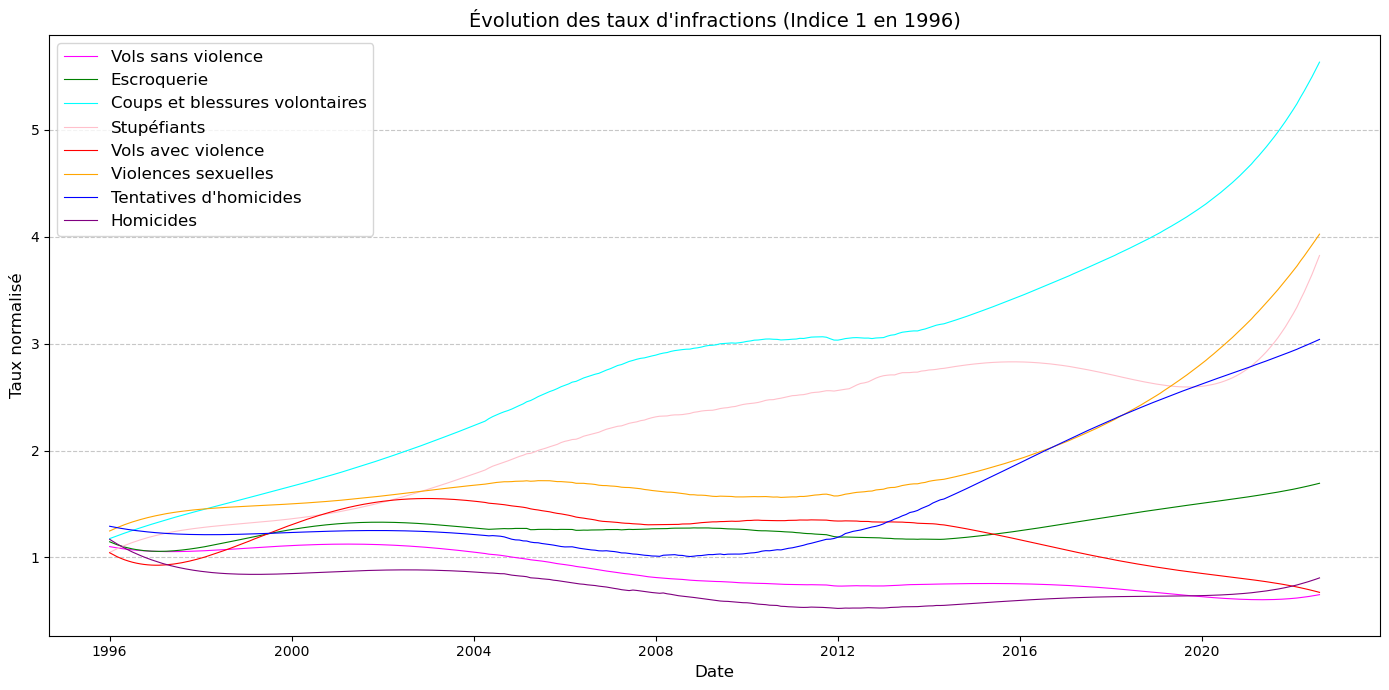

In [ ]:


def tracer_evolution_taux_relatif_lisse(df, charte_graphique, title="Évolution des taux d'infractions (Indice 1 en 1996)", xlabel="Date", ylabel="Taux normalisé"):
    """
    Trace l'évolution des taux normalisés pour une liste d'indicateurs.

    Args:
        df (pd.DataFrame): Le dataframe contenant les données.
        charte_graphique (dict): Dictionnaire {nom_indicateur: couleur}.
        title (str): Titre du graphique.
        xlabel (str): Label de l'axe des x.
        ylabel (str): Label de l'axe des y.
    """

    window_length = 200
    polyorder = 5

    plt.figure(figsize=(14, 7))

    for indicateur, couleur in charte_graphique.items():
        # Extraire les données pour l'indicateur
        filtre = df['Indicateur'] == indicateur
        data_indicateur = df.loc[filtre].copy()


        # Normaliser les valeurs en divisant par la valeur initiale (1996)
        valeur_initiale = data_indicateur.iloc[0]['Taux (/10 000)']
        data_indicateur['Taux normalisé'] = data_indicateur['Taux (/10 000)'] / valeur_initiale
        #data_indicateur = data_indicateur[(data_indicateur['Date'] >= "2019-01-01") & (data_indicateur['Date'] <= "2021-01-01")]
        # Appliquer un lissage aux taux relatifs avec Savitzky-Golay
        if len(data_indicateur) >= window_length:
            taux_lisse = savgol_filter(data_indicateur['Taux relatif'], window_length=window_length, polyorder=polyorder)
        else:
            taux_lisse = data_indicateur['Taux relatif']  # Pas de lissage si pas assez de points
        # Tracer la courbe
        plt.plot(
            data_indicateur['Date'], 
            taux_lisse, 
            color=couleur, 
            linewidth=0.8, 
            label=indicateur
        )

    # Ajouter des titres, légendes et la grille
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajustement et affichage
    plt.tight_layout()
    plt.show()

tracer_evolution_taux_relatif_lisse(df_indicateurs_nat, charte_graphique)

In [ ]:

# Fonction pour tracer le boxplot avec couleurs personnalisées pour chaque saison
def boxplot_indicateur_par_saison(indicateur):
    # Ajouter la colonne 'Saison' au dataframe
    
    # Filtrer les données pour l'indicateur spécifié
    df_indicateur_filtre = df_indicateurs_nat[df_indicateurs_nat['Indicateur'] == indicateur]
    
    # Définir les couleurs pour chaque saison
    saison_colors = {
        'Hiver': 'cornflowerblue',  # Bleu clair pour l'hiver
        'Printemps': 'limegreen',  # Vert clair pour le printemps
        'Été': 'gold',  # Jaune orangé pour l'été
        'Automne': 'brown'  # Marron-rouge pour l'automne
    }
    
    # Créer le boxplot avec la palette de couleurs définie
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Saison', y='Taux (/10 000)', data=df_indicateur_filtre, 
                palette=saison_colors)
    
    # Ajouter un titre et des labels
    plt.title(f'Boxplot du taux de {indicateur} selon les saisons')
    plt.xlabel('Saison')
    plt.ylabel('Taux (/10 000)')
    
    # Afficher le plot
    plt.show()

/tmp/ipykernel_39183/1476782343.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Saison', y='Taux (/10 000)', data=df_indicateur_filtre,
/tmp/ipykernel_39183/1476782343.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.boxplot(x='Saison', y='Taux (/10 000)', data=df_indicateur_filtre,


UnboundLocalError: cannot access local variable 'boxprops' where it is not associated with a value

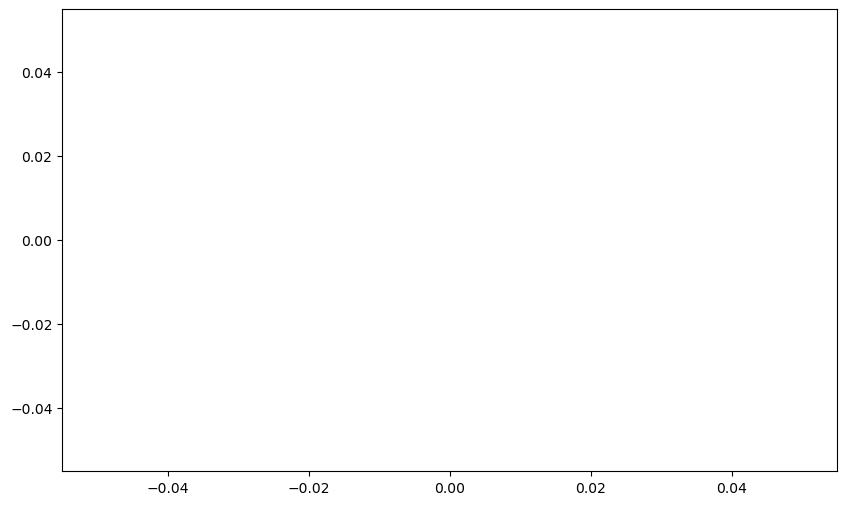

In [ ]:
boxplot_indicateur_par_saison("Vols sans violence")


Là on passe à la partie descriptive géographique.

On a essayé mais on n'a pas réussi à afficher une carte animée de la France donc on a décidé d'implémenter une fonction qui permet d'obtenir les cartes de répartition des taux d'un indicateur pour chaque année entre 1996 et 2022 pour en constater l'évolution.

In [ ]:

def évolution_indicateur(indicateur):
    # Définir le nombre de cartes par ligne
    cartes_par_ligne = 7
    
    # Calculer le nombre de lignes nécessaires
    total_annees = 2022 - 1996 + 1
    lignes = (total_annees // cartes_par_ligne) + (1 if total_annees % cartes_par_ligne != 0 else 0)
    
    # Créer une figure avec une taille ajustée pour les petites cartes
    fig, axes = plt.subplots(nrows=lignes, ncols=cartes_par_ligne, figsize=(12, lignes * 2))
    
    # Aplatir la liste des axes pour y accéder plus facilement
    axes = axes.flatten()

    # Créer une liste pour stocker les valeurs des taux pour l'échelle partagée
    taux_values = []

    # Parcours des années de 1996 à 2022
    for idx, annee in enumerate(range(1996, 2023)):
        # Filtrer les données pour l'indicateur et l'année en cours
        df_filtre = df_indicateurs_dep[(df_indicateurs_dep['Année'] == str(annee)) & (df_indicateurs_dep['Indicateur'] == indicateur)]
        
        # Créer un GeoDataFrame avec la colonne 'Géométrie'
        gdf = gpd.GeoDataFrame(df_filtre, geometry='Géométrie')
        
        # Ajouter les valeurs des taux dans la liste pour l'échelle partagée
        taux_values.extend(gdf['Taux (/10 000)'].dropna().tolist())
        
        # Vérifier si le GeoDataFrame n'est pas vide
        if not gdf.empty:
            # Afficher la carte avec le taux (%) sur l'axe correspondant
            gdf.plot(column='Taux (/10 000)', cmap=charte_graphique2.get(f'{indicateur}'), ax=axes[idx], legend=False)
            
            # Titre de la carte
            axes[idx].set_title(f"{annee}", fontsize=6)
            axes[idx].axis("off")  # Enlever les axes
            axes[idx].set_aspect(1.4)
        else:
            axes[idx].axis("off")  # Si aucune donnée, ne pas afficher d'axes

    # Créer un ScalarMappable pour la légende partagée
    sm = plt.cm.ScalarMappable(cmap=charte_graphique2.get(f'{indicateur}'), norm=mpl.colors.Normalize(vmin=min(taux_values), vmax=max(taux_values)))
    sm.set_array([])  # Nécessaire pour la légende
    
    # Ajouter la légende commune à la dernière case vide (celle qui reste vide)
    cbar = fig.colorbar(sm, 
                        ax=axes[-1], 
                        orientation='horizontal', 
                        fraction=0.045, 
                        pad=0.06, 
                        label="Occurences pour \n 10 000 habitants")

    # Supprimer le contour de la dernière case où la légende est placée
    axes[-1].axis("off")

    fig.suptitle(f"{indicateur}", fontsize=13, fontweight='bold', y=0.68) # titre commun

    # Ajuster l'espacement pour les sous-graphes et la légende
    plt.subplots_adjust(hspace=0.1, bottom=0, top=0.6)  # Ajuster l'espacement vertical et l'espacement en bas
    
    # Afficher la figure
    plt.show()

ValueError: Unknown column Géométrie

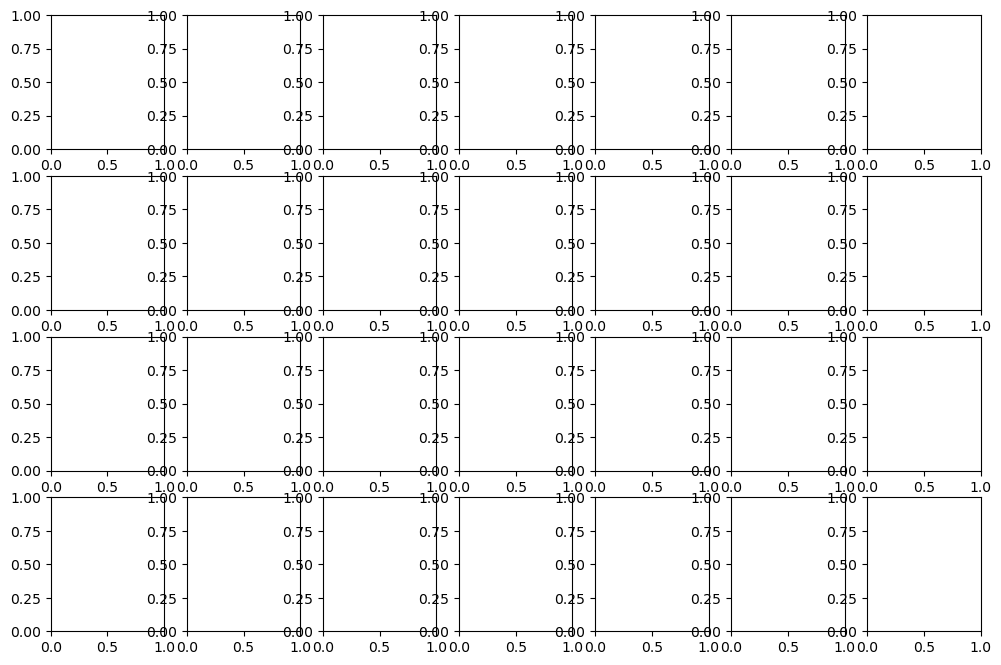

In [ ]:
évolution_indicateur("Vols sans violence")

In [ ]:
def évolution_indicateur_2(df, indicateur):
    """
    Génère une série de cartes pour visualiser l'évolution annuelle d'un indicateur.

    Arguments :
        df : DataFrame contenant les données, avec les colonnes 'Année', 'Indicateur', 'Département' et 'Taux (/10 000)'.
        indicateur : Nom de l'indicateur à visualiser (str).
    """
    # Définir le nombre de cartes par ligne
    cartes_par_ligne = 7
    
    # Calculer le nombre de lignes nécessaires
    total_annees = 2022 - 1996 + 1
    lignes = (total_annees // cartes_par_ligne) + (1 if total_annees % cartes_par_ligne != 0 else 0)
    
    # Créer une figure avec une taille ajustée pour les petites cartes
    fig, axes = plt.subplots(nrows=lignes, ncols=cartes_par_ligne, figsize=(12, lignes * 2))
    
    # Aplatir la liste des axes pour y accéder plus facilement
    axes = axes.flatten()

    # Créer une liste pour stocker les valeurs des taux pour l'échelle partagée
    taux_values = []

    # Parcours des années de 1996 à 2022
    for idx, annee in enumerate(range(1996, 2023)):
        # Filtrer les données pour l'indicateur et l'année en cours
        df_filtre = df[
            (df['Année'] == str(annee)) & 
            (df['Indicateur'] == indicateur)
        ]
        
        # Ajouter une colonne 'geometry' en mappant le dictionnaire de géométrie sur la colonne 'Département'
        df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)

        # Créer un GeoDataFrame avec la nouvelle colonne 'geometry'
        gdf = gpd.GeoDataFrame(df_filtre, geometry="geometry")
        
        # Ajouter les valeurs des taux dans la liste pour l'échelle partagée
        taux_values.extend(gdf['Taux (/10 000)'].dropna().tolist())
        
        # Vérifier si le GeoDataFrame n'est pas vide
        if not gdf.empty:
            # Afficher la carte avec le taux (%) sur l'axe correspondant
            gdf.plot(
                column='Taux (/10 000)', 
                cmap=charte_graphique2.get(f'{indicateur}'), 
                ax=axes[idx], 
                legend=False
            )
            
            # Titre de la carte
            axes[idx].set_title(f"{annee}", fontsize=6)
            axes[idx].axis("off")  # Enlever les axes
            axes[idx].set_aspect(1.4)
        else:
            axes[idx].axis("off")  # Si aucune donnée, ne pas afficher d'axes

    # Créer un ScalarMappable pour la légende partagée
    sm = plt.cm.ScalarMappable(
        cmap=charte_graphique2.get(f'{indicateur}'), 
        norm=mpl.colors.Normalize(vmin=min(taux_values), vmax=max(taux_values))
    )
    sm.set_array([])  # Nécessaire pour la légende
    
    # Ajouter la légende commune à la dernière case vide (celle qui reste vide)
    cbar = fig.colorbar(
        sm, 
        ax=axes[-1], 
        orientation='horizontal', 
        fraction=0.045, 
        pad=0.06, 
        label="Occurences pour \n 10 000 habitants"
    )

    # Supprimer le contour de la dernière case où la légende est placée
    axes[-1].axis("off")

    fig.suptitle(f"{indicateur}", fontsize=13, fontweight='bold', y=0.68)  # titre commun

    # Ajuster l'espacement pour les sous-graphes et la légende
    plt.subplots_adjust(hspace=0.1, bottom=0, top=0.6)  # Ajuster l'espacement vertical et l'espacement en bas
    
    # Afficher la figure
    plt.show()


/tmp/ipykernel_8219/828258686.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/tmp/ipykernel_8219/828258686.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre["geometry"] = df_filtre["Département"].map(dictionnaire_geo)
/tmp/ipykernel_8219/828258686.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

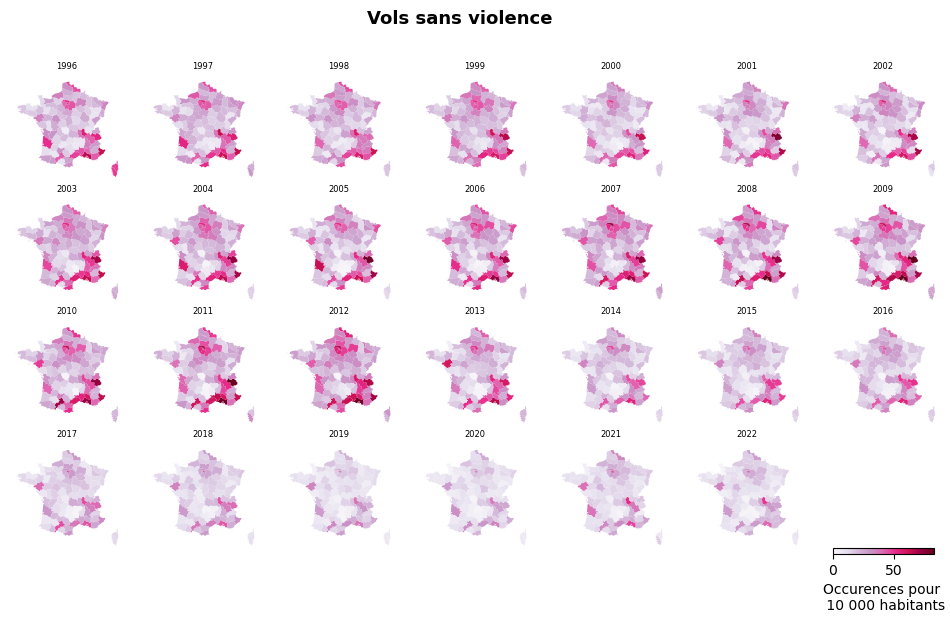

In [ ]:
évolution_indicateur_2(df_indicateurs_dep, "Vols sans violence")

In [ ]:
def evolution_indicateur_animation(df, indicateur):

    plt.ioff()
    
    # Préparer la figure et l'axe
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Créer une liste des années de 1996 à 2022
    annees = list(range(1996, 2023))
    
    # Fonction d'initialisation pour l'animation
    def init():
        ax.clear()
        ax.set_title(f"{indicateur} - Initialisation")
        ax.axis("off")
        return []
    
    # Fonction de mise à jour pour chaque frame de l'animation
    def update(frame):
        ax.clear()
        annee = annees[frame]
        
        # Filtrer les données pour l'indicateur et l'année en cours
        df_filtre = df[(df['Année'] == str(annee)) & (df['Indicateur'] == indicateur)]
        
        # Créer un GeoDataFrame avec la colonne 'Géométrie'
        gdf = gpd.GeoDataFrame(df_filtre, geometry='Géométrie')
        
        # Vérifier si le GeoDataFrame n'est pas vide
        if not gdf.empty:
            # Calculer les limites de couleur
            vmin = df[df['Indicateur'] == indicateur]['Taux (/10 000)'].min()
            vmax = df[df['Indicateur'] == indicateur]['Taux (/10 000)'].max()
            
            # Tracer la carte
            gdf.plot(column='Taux (/10 000)', 
                     cmap=charte_graphique2.get(f'{indicateur}'), 
                     ax=ax, 
                     legend=False,
                     vmin=vmin,
                     vmax=vmax,
                     edgecolor='0.8',
                     linewidth=0.7)
            
            # Titre de la carte
            ax.set_title(f"{indicateur} - {annee}")
        
        ax.axis("off")
        ax.set_aspect('equal')  
        ax.set_aspect(1.4)  # Étirement vertical de la carte
        
        return []
    
    # Créer l'animation
    anim = animation.FuncAnimation(fig, 
                                   update, 
                                   init_func=init,
                                   frames=len(annees), 
                                   interval=500,  # 500 ms entre chaque frame
                                   blit=True)
    
    # Ajouter une barre de couleur
    vmin = df[df['Indicateur'] == indicateur]['Taux (/10 000)'].min()
    vmax = df[df['Indicateur'] == indicateur]['Taux (/10 000)'].max()
    sm = plt.cm.ScalarMappable(cmap=charte_graphique2.get(f'{indicateur}'), norm=colors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.1, label="Occurences pour 10 000 habitants")
    
    # Sauvegarder l'animation au format GIF
    # Crée un dossier 'animations' s'il n'existe pas
    os.makedirs('animations', exist_ok=True)
    
    # Chemin de sauvegarde
    save_path = f'animations/evolution_{indicateur.replace(" ", "_")}.gif'
    
    # Sauvegarde en GIF (plus compatible)
    anim.save(save_path, writer='pillow', fps=2)

    # Utiliser IPython.display pour afficher le GIF (utiliser matplotlib d'afficherait qu'une des frame)
    display(Image(filename=save_path))
    
    print(f"Animation sauvegardée dans {save_path}")
    
    return anim


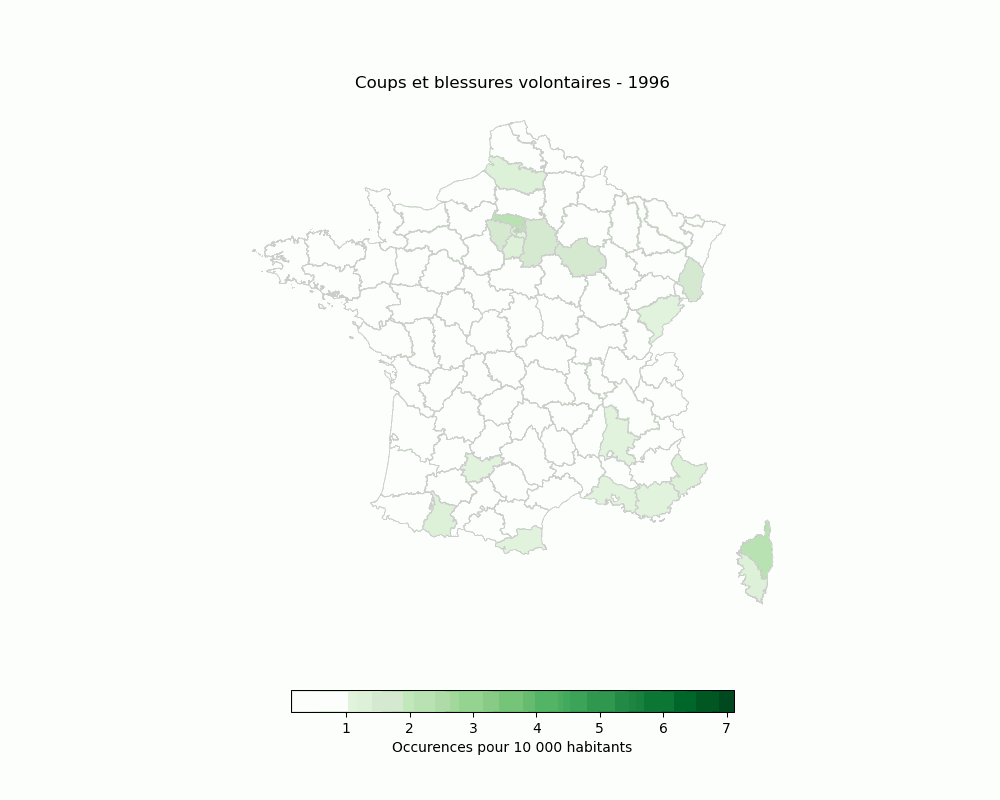

Animation sauvegardée dans animations/evolution_Coups_et_blessures_volontaires.gif


In [ ]:
evolution_indicateur_animation(df_indicateurs_dep, 'Coups et blessures volontaires')

'''

URL de téléchargement du fichier zipé répertoriant la population française totale par mois depuis aout 1996
https://www.insee.fr/fr/statistiques/serie/telecharger/csv/000436387?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1996&periodeFin=8&anneeFin=2022&revision=sansrevisions

URL de déléchargement du fichier répertoriant la population par département depuis 1996 (granularité annuelle pas mensuelle mais on fait comme on peut)
https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION/to-csv?maxResult=10000&SEX=_T&AGE=_T&TIME_PERIOD=1996&TIME_PERIOD=1997&TIME_PERIOD=1998&TIME_PERIOD=1999&TIME_PERIOD=2000&TIME_PERIOD=2001&TIME_PERIOD=2002&TIME_PERIOD=2003&TIME_PERIOD=2004&TIME_PERIOD=2005&TIME_PERIOD=2006&TIME_PERIOD=2007&TIME_PERIOD=2008&TIME_PERIOD=2009&TIME_PERIOD=2010&TIME_PERIOD=2011&TIME_PERIOD=2012&TIME_PERIOD=2013&TIME_PERIOD=2014&TIME_PERIOD=2015&TIME_PERIOD=2016&TIME_PERIOD=2017&TIME_PERIOD=2018&TIME_PERIOD=2019&TIME_PERIOD=2020&TIME_PERIOD=2021&TIME_PERIOD=2022&GEO=DEP&optionCsv=%7B%22format%22:%22csv%22,%22affichage%22:%22codes%22,%22decimales%22:%22point%22,%22periodeColonne%22:false,%22lang%22:%22fr%22%7D

'''
